# Task 5: Clustering and Association Rule Mining

### 1. Introduction & Objectives

Compared to previous tasks where we have had datasets with already labeled samples with the target already known in the data. In this task we will be using clustering to group datapoints, by splitting them based on similarity of features.
We will also be diving in to association rule mining to find relationships between variables.



### 2. Understanding the Data

#### Loading the data and a quick preview
We will load the data in two sets, as the files are two different csv files, split between customer locations and product groups.

First its always a good idea to take a peak at the data and see what it looks like in its raw form:

In [2]:
import pandas as pd

cust_df = pd.read_csv("../Datasets/drone_cust_locations.csv", delimiter=";") # delimiter used to tell that file uses ; as delimiter

cust_df.head(5)

,clientid,x,y
0,1,622.771572,164.857623
1,2,416.357298,630.193634
2,3,292.735020,567.333231
3,4,737.211288,166.225676
4,5,540.475375,682.912298


Just to be on the safe side, one should always do a check, if the file we are working with has null value points in it.

In [3]:
missing_values = cust_df.isnull().sum()
missing_values

clientid    0
x           0
y           0
dtype: int64

In [4]:
cust_df.dtypes

clientid      int64
x           float64
y           float64
dtype: object

#### Plotting the client location data

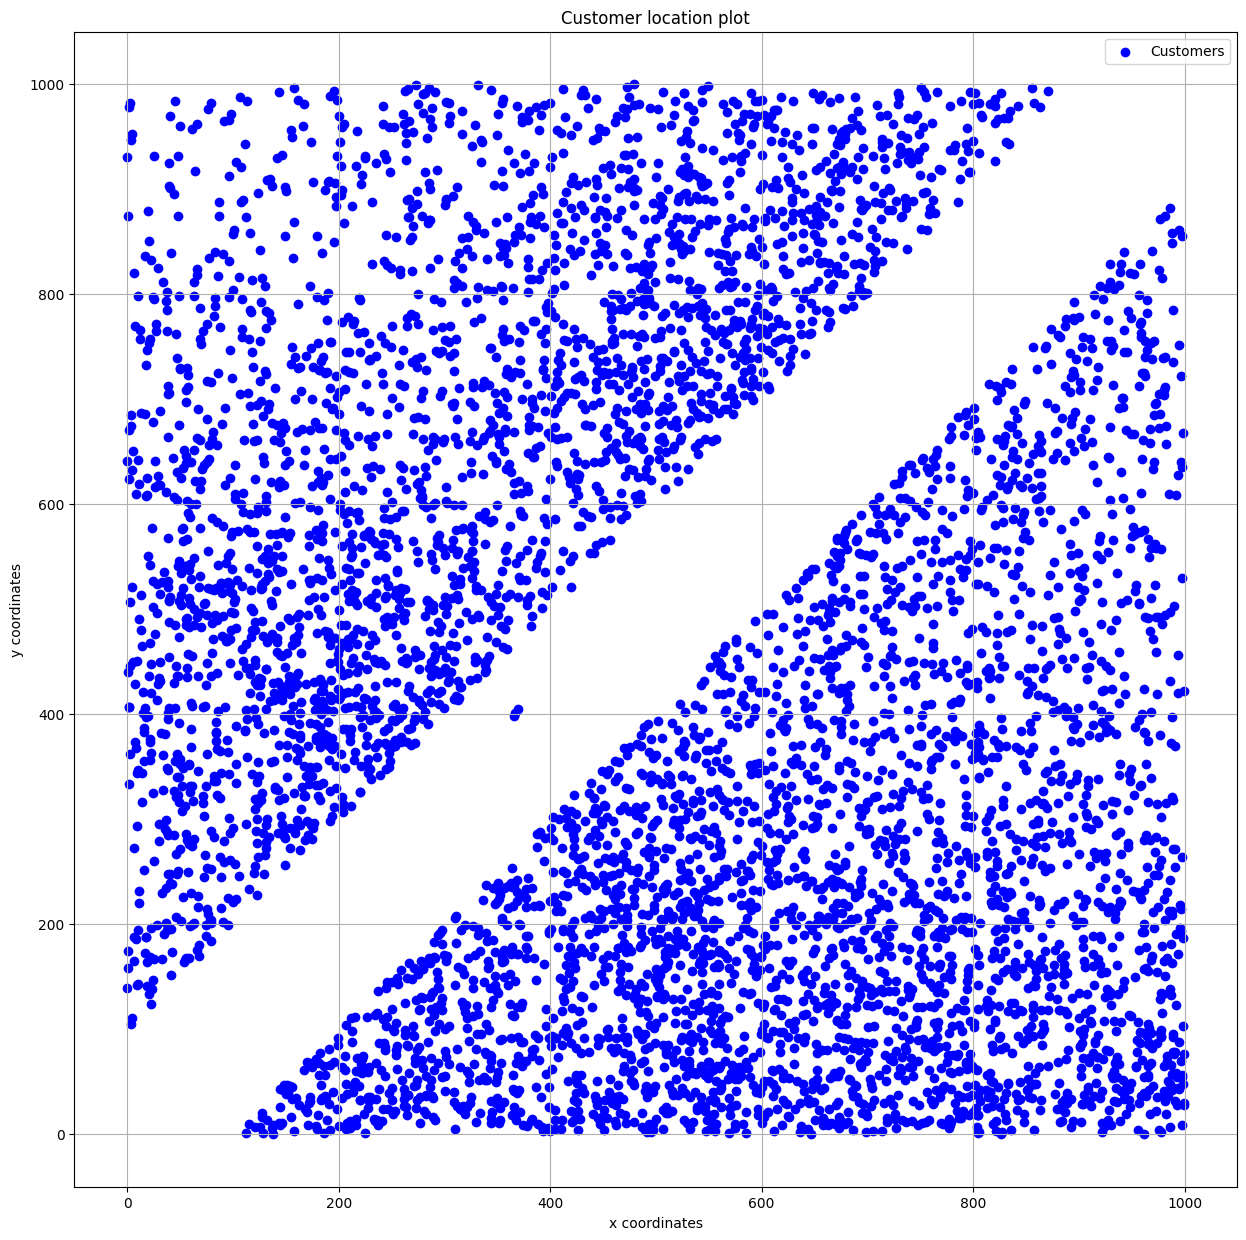

In [5]:
import matplotlib.pyplot as plt

x_coords = cust_df["x"]
y_coords = cust_df["y"]
plt.figure(figsize=(15, 15))
plt.scatter(x_coords, y_coords, color="blue", label="Customers")

#labels and title
plt.title("Customer location plot")
plt.xlabel("x coordinates")
plt.ylabel("y coordinates")


plt.grid(True)
plt.legend()
plt.show()



This scatter plot gives us an idea of how the customers are laid out on a 2d map. A geographical interpretation would be a location with a river in going through the middle, with a small island with a couple of customers on it. Next we should find the optimal locations for the drone depots.

### 3. Data preparation
Preparing the data for operations, where we will be taking a closer look at the clustering based on kMeans clustering and later on we take a stab at agglomerative hierarchical clustering.

We start with creating the clusters using the 3 depots as the centroids. We will use the whole of the data, as there is (probably) most use to use all the allotted data to search for the best possible clusters.

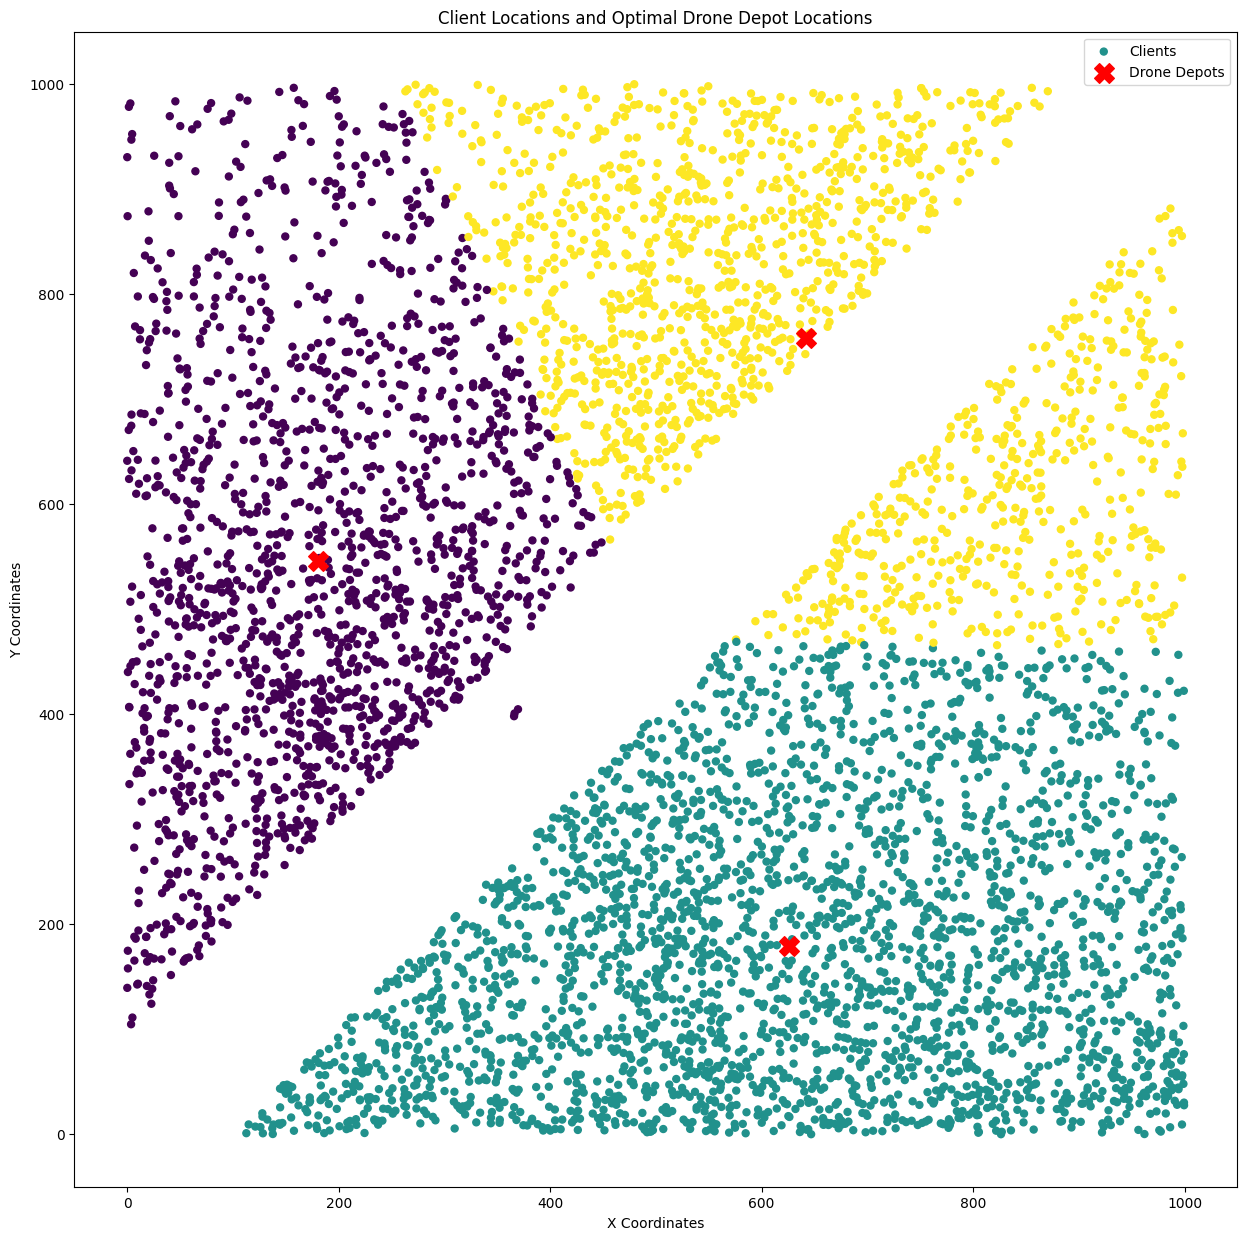

Optimal depot locations (x, y coordinates):
Depot 1: (180.89854773860907, 546.0231999426724)
Depot 2: (626.3051479817534, 179.09663220366969)
Depot 3: (641.7820168938401, 758.3416727389254)


In [6]:
from sklearn.cluster import KMeans
n_depots = 3

# Extract x and y coordinates
X = cust_df[['x', 'y']]

# Perform K-means clustering to find n clusters
kmeans = KMeans(n_clusters=n_depots, random_state=42)
cust_df['cluster'] = kmeans.fit_predict(X) # create new column which slots the customer to a specific drone depot cluster

#centroids (depot locations)
centroids = kmeans.cluster_centers_

# Plotting
plt.figure(figsize=(15, 15))
plt.scatter(cust_df['x'], cust_df['y'], c=cust_df['cluster'], cmap='viridis', label='Clients', s=100, marker='.')

# Mark the depot locations (centroids)
# centroids[:,0] extracts 1st columns (x coords) and centroids[:,1] second column (y coords)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Drone Depots')

plt.title('Client Locations and Optimal Drone Depot Locations')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')


plt.legend()
plt.show()

# Print depot locations (centroids)
print("Optimal depot locations (x, y coordinates):")
for i, centroid in enumerate(centroids):
    print(f"Depot {i+1}: ({centroid[0]}, {centroid[1]})")


The scatter plot has been plotted to display each of the three drone depot clients by different colors so we can easily differentiate between the different clienteles and their depots.

We were also tasked to create a dataframe that combines clients with their depots. In the code above the upper plot on line 9 we have done that and below we check the results of the 

In [7]:
cust_df.head(10)

,clientid,x,y,cluster
0,1,622.771572,164.857623,1
1,2,416.357298,630.193634,0
2,3,292.735020,567.333231,0
3,4,737.211288,166.225676,1
4,5,540.475375,682.912298,2
5,6,535.469492,318.439661,1
6,7,640.380050,870.833221,2
7,8,235.772075,359.048203,0
8,9,481.896884,661.491838,2
9,10,730.032789,312.177817,1


#### Trying different n_depots
With clustering, it is hard to have certainty in the optimal amount of clusters. One method to make it a bit easier to discern fromt optimal amounts of clusters is the elbow method. Let's build the plot for measuring optimal n_depots. 


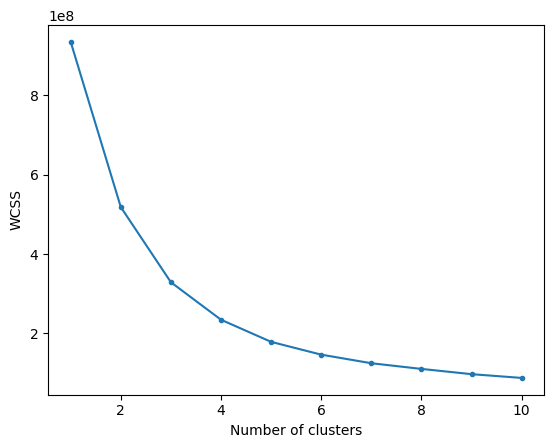

In [8]:
wcss = []
for i in range(1,11):
    model = KMeans(init='random', n_clusters=i, random_state=42).fit(X)
    wcss.append(model.inertia_)
    
plt.plot(range(1,11), wcss, '.-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

With the graph plotted, we can see that the optimal amount seems to be three or four clusters/(depots). In this graph the elbow is quite linear, and a clear cutoff point is harder to discern but after the k reaches 3 the returns of using more cluster promises only minimal improvements. Another popular measure is the silhouette score:

In [9]:
from sklearn.metrics import silhouette_score
n_clusters_list = [2, 3, 4, 5, 6,10]

# Loop over each n_clusters and calculate the silhouette score
for n_clusters in n_clusters_list:
    model = KMeans(init='random', n_clusters=n_clusters, random_state=42).fit(X)
    labels = model.labels_
    score = silhouette_score(X, labels)
    
    print(f'Silhouette score for {n_clusters} clusters = {score:.2f}')

Silhouette score for 2 clusters = 0.42
Silhouette score for 3 clusters = 0.42
Silhouette score for 4 clusters = 0.40
Silhouette score for 5 clusters = 0.42
Silhouette score for 6 clusters = 0.40
Silhouette score for 10 clusters = 0.37


From these scores we can see that, none of the values of k give us a reasonable (s>=0.5) or strong (s>=0.75). This might be due to the amount af data used and the value that silhouette score measures, as we have a lot of datapoint near each other, the spacing between them is so dense that we simply can not get better silhouette scores. 

Next up we will try clustering with 10 clusters and see the difference in the generated plot. 

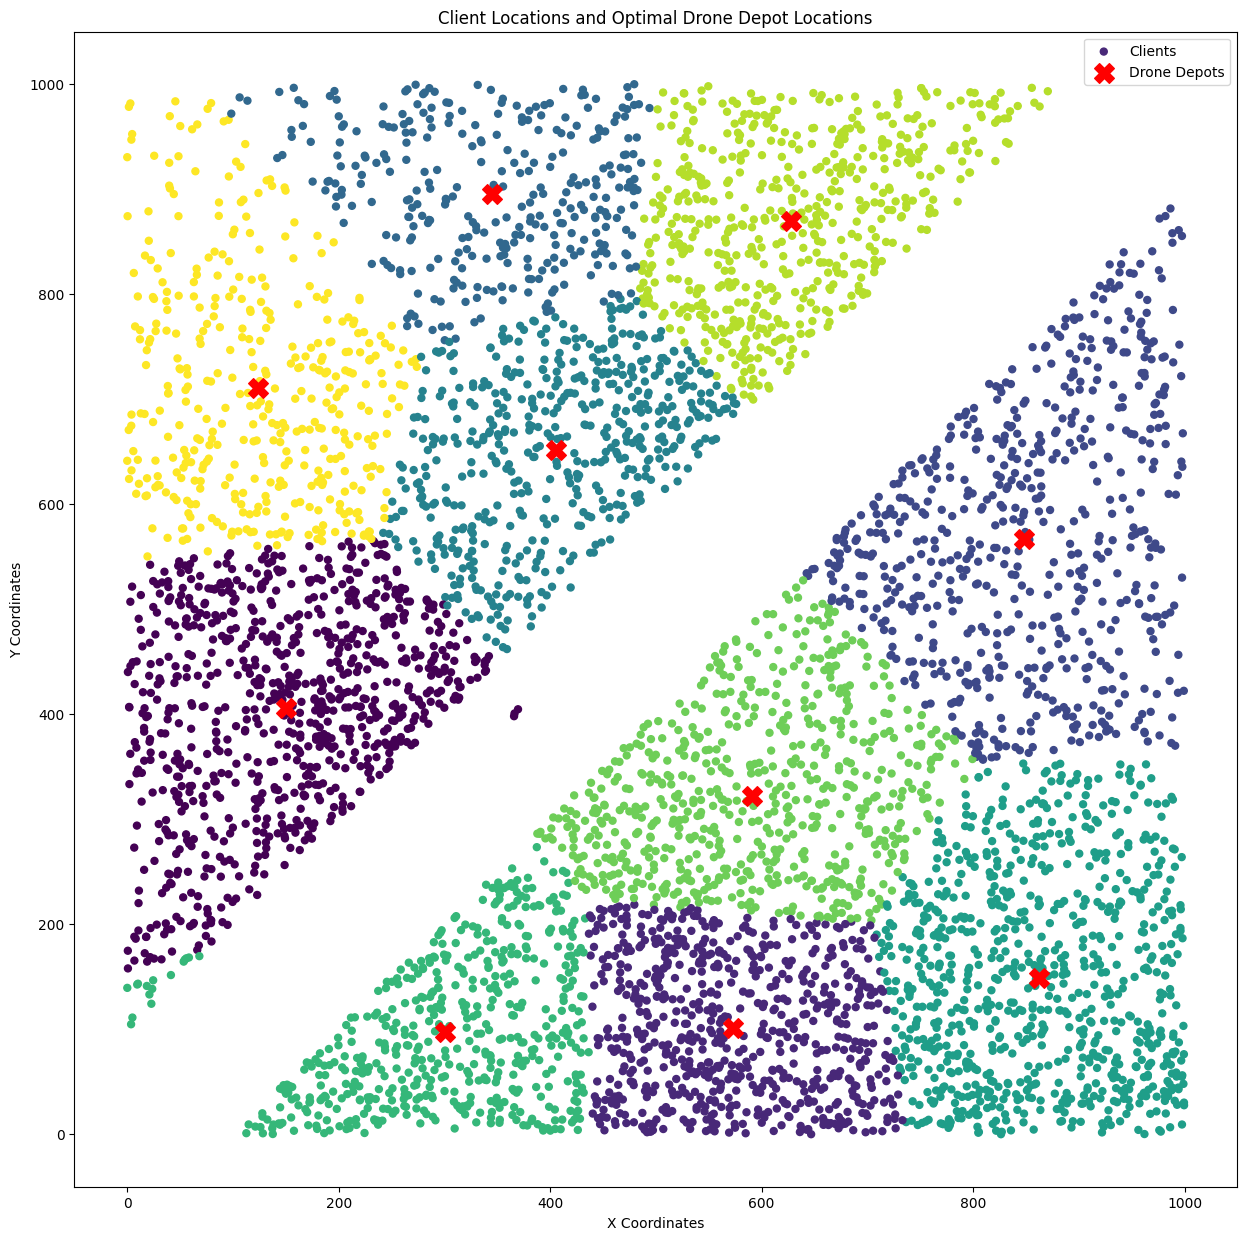

In [10]:
n_depots = 10

# x and y coordinates from dataframe
X = cust_df[['x', 'y']]

# Perform K-means clustering to find n clusters
kmeans = KMeans(n_clusters=n_depots, random_state=42)
cust_df['cluster'] = kmeans.fit_predict(X) # create new column which slots the customer to a specific drone depot cluster

# centroids (depot locations)
centroids = kmeans.cluster_centers_

# Plotting
plt.figure(figsize=(15, 15))
plt.scatter(cust_df['x'], cust_df['y'], c=cust_df['cluster'], cmap='viridis', label='Clients', s=100, marker='.')

# plot depot locations (centroids)
# centroids[:,0] extracts 1st columns (x coords) and centroids[:,1] second column (y coords)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Drone Depots')

plt.title('Client Locations and Optimal Drone Depot Locations')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')


plt.legend()
plt.show()

#### Hierarchical clustering
Next up well replace k-means clustering with agglomerative hierarchical clustering and explore what differences we can find with using a different clustering approach to see what sort of end results we get from a different approach to the same issue.

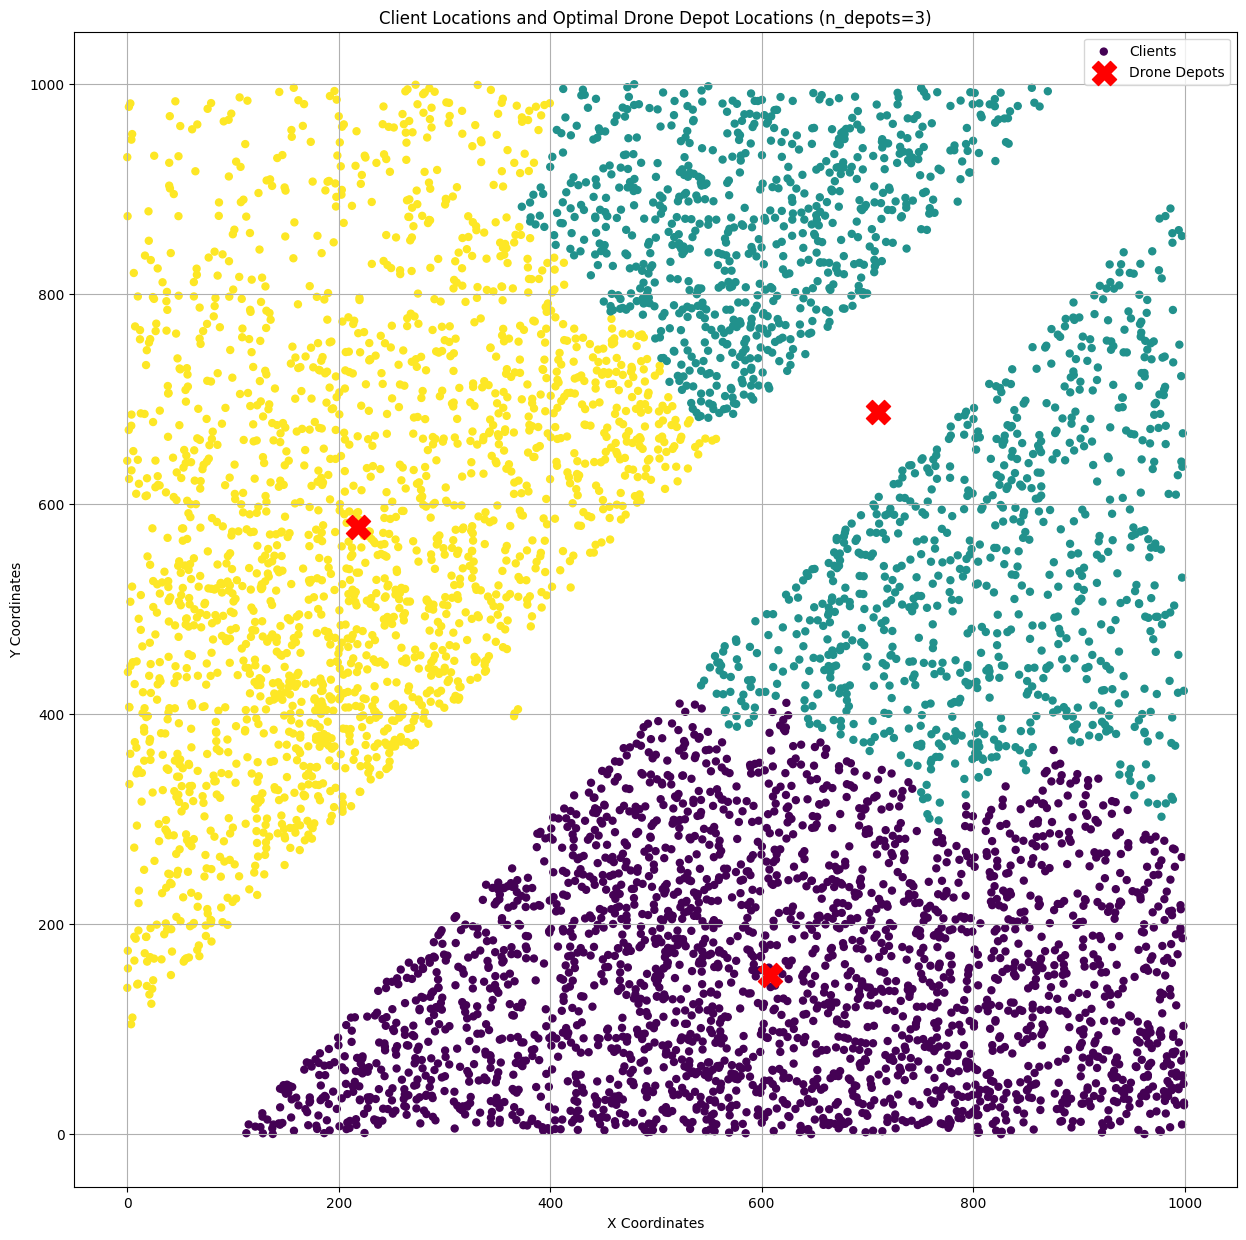

In [11]:
from sklearn.cluster import AgglomerativeClustering

def perform_agglomerative_clustering(agg_X, agg_n_clusters):
    agg_model = AgglomerativeClustering(n_clusters=agg_n_clusters)
    clusters = agg_model.fit_predict(agg_X)
    return clusters


# List if we want to test multiple clusters at the same time
depot_numbers = [3]  

for n_depots in depot_numbers:
    # Agglomerative Clustering
    cust_df['cluster'] = perform_agglomerative_clustering(X, agg_n_clusters=n_depots)

    # Plot results
    plt.figure(figsize=(15, 15))
    plt.scatter(cust_df['x'], cust_df['y'], c=cust_df['cluster'], cmap='viridis', label='Clients', s=100, marker='.')

    
    centroids = cust_df.groupby('cluster')[['x', 'y']].mean().values

    # Mark the depot locations (calculated centroids)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=300, label='Drone Depots')

    # Add labels and title
    plt.title(f'Client Locations and Optimal Drone Depot Locations (n_depots={n_depots})')
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')

    # Enable grid and legend
    plt.grid(True)
    plt.legend()
    plt.show()


One difference that we can make instantly from the 3 depots graph is that agglomerative hierarchical clustering has placed a depot in the "river" where the depot may or may not be placed depending on the real geographical attributes of the empty space.



### Conclusions to drone depot locations
When looking at the Silhouette score, we can see that with such high customer density we would be ok with only 2 depots, but when we refer to the elbow method we can see that the most return on investment is either with 2 or three depots. As with the difference with the two methods used to calculate the best layouts, we need to consider the geographical features of this supposed customer map.

### 4. Interesting relationships between product groups

Next up we will be looking at the product groups and the relationships between them. We will be using the apriori algorithm to find the relationships between the different product groups.

In [16]:
product_df = pd.read_csv("../Datasets/drone_prod_groups.csv")
product_df.drop('ID', axis=1, inplace=True)
product_df.head(5)

,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7,Prod8,Prod9,Prod10,Prod11,Prod12,Prod13,Prod14,Prod15,Prod16,Prod17,Prod18,Prod19,Prod20
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1
3,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1


Now that we have the data loaded in, we can check the file for missing values.

In [17]:
missing_values = product_df.isnull().sum()
missing_values

Prod1      0
 Prod2     0
 Prod3     0
 Prod4     0
 Prod5     0
 Prod6     0
 Prod7     0
 Prod8     0
 Prod9     0
 Prod10    0
 Prod11    0
 Prod12    0
 Prod13    0
 Prod14    0
 Prod15    0
 Prod16    0
 Prod17    0
 Prod18    0
 Prod19    0
 Prod20    0
dtype: int64

As we can see, the data is clean and ready for the next steps. Next up we will be using the apriori algorithm to find the relationships between the different product groups.

#### Apriori algorithm

The apriori algorithm is a popular algorithm used in association rule mining. It is used to find relationships between different variables in a dataset. The algorithm works by finding frequent itemsets in the data and then using these itemsets to generate association rules.

To get started, we first must convert the data into boolean values, as the apriori algorithm requires the data to be in this format.

In [31]:
from mlxtend.frequent_patterns import apriori, association_rules

product_df = product_df.astype(bool)

frequent_itemsets = apriori(product_df, min_support=0.1, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.10998,(Prod1)
1,0.13098,( Prod2)
2,0.10459,( Prod5)
3,0.13499,( Prod7)
4,0.16179,( Prod8)
5,0.19853,( Prod9)
6,0.10848,( Prod11)
7,0.15971,( Prod12)
8,0.14557,( Prod14)
9,0.11880,( Prod15)


The table above shows the frequent itemsets in the data. The support column shows the proportion of transactions that contain the itemset. Next, we will generate association rules from the frequent itemsets.

In [30]:
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( Prod15),( Prod9),0.11880,0.19853,0.11145,0.938131,4.725388,0.087865,12.954372,0.894663
1,( Prod9),( Prod15),0.19853,0.11880,0.11145,0.561376,4.725388,0.087865,2.009011,0.983664
2,( Prod20),( Prod19),0.14798,0.20626,0.13476,0.910664,4.415125,0.104238,8.884845,0.907849
3,( Prod19),( Prod20),0.20626,0.14798,0.13476,0.653350,4.415125,0.104238,2.457869,0.974508


The table above shows the association rules generated from the frequent itemsets. The antecedents column shows the items that are present in the rule's antecedent, while the consequents column shows the items in the rule's consequent. The support column shows the proportion of transactions that contain both the antecedent and consequent, while the confidence column shows the proportion of transactions that contain the consequent given that they contain the antecedent.

We can now sort the rules by lift to find the most interesting relationships between the product groups.

In [29]:
sorted_rules = rules.sort_values(by=['lift', 'confidence'], ascending=False)
sorted_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( Prod15),( Prod9),0.11880,0.19853,0.11145,0.938131,4.725388,0.087865,12.954372,0.894663
1,( Prod9),( Prod15),0.19853,0.11880,0.11145,0.561376,4.725388,0.087865,2.009011,0.983664
2,( Prod20),( Prod19),0.14798,0.20626,0.13476,0.910664,4.415125,0.104238,8.884845,0.907849
3,( Prod19),( Prod20),0.20626,0.14798,0.13476,0.653350,4.415125,0.104238,2.457869,0.974508


The table above shows the association rules sorted by lift and confidence. The lift column shows the ratio of the observed support to that expected if the two rules were independent. The higher the lift, the stronger the association between the antecedent and consequent.

### 5. Conclusions to Association Rule Mining

The goal of this analysis was to uncover interesting relationships between product groups in the dataset. Using the Apriori algorithm, we were able to identify several strong association rules between product groups. These rules suggest that certain products are frequently purchased together, which can be valuable information for marketing and sales strategies.

The results highlighted significant associations, particularly between **Prod15** and **Prod9**, and between **Prod20** and **Prod19**. These findings indicate that customers who buy one of these products are highly likely to purchase the other, presenting opportunities for targeted cross-selling and product bundling.

**Key insights include:**
1. **High Confidence in Product Associations**: The high confidence levels of the identified rules underscore the reliability of these associations, suggesting that they can be effectively leveraged in marketing campaigns.
2. **Potential for Increased Revenue**: By implementing strategies such as cross-selling, bundling, and optimized product placements based on the discovered relationships, the company can enhance customer purchasing behavior and increase the average transaction value.
3. **Strategic Marketing Initiatives**: The insights gained can inform the design of targeted marketing initiatives, such as personalized promotions and recommendations that resonate with customer purchasing patterns.

Overall, by utilizing the findings from this analysis, the company can strategically enhance its marketing and sales efforts, thereby maximizing revenue and improving customer satisfaction through tailored product offerings.
